In [2]:
import tensorflow as tf 
import tensorflow.keras 
from tensorflow.keras.models import Sequential, Model, model_from_json
from tensorflow.keras.layers import Dense, Conv2D, Activation, MaxPool2D, Flatten, Dropout, BatchNormalization

import numpy as np 
import pandas as pd

In [3]:
IM_PATH = 'D:/Workspace/Datasets/Faces/FacialExpression/fer2013.csv'

df = pd.read_csv(IM_PATH)
df.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [4]:
df['Usage'].value_counts()

Training       28709
PrivateTest     3589
PublicTest      3589
Name: Usage, dtype: int64

In [5]:
train = df[['emotion', 'pixels']][df['Usage'] == 'Training']
train.isnull().sum()
train.shape

(28709, 2)

In [6]:
train['pixels'] = train['pixels'].apply(lambda im: np.fromstring(im, sep=' '))

train['pixels']

0        [70.0, 80.0, 82.0, 72.0, 58.0, 58.0, 60.0, 63....
1        [151.0, 150.0, 147.0, 155.0, 148.0, 133.0, 111...
2        [231.0, 212.0, 156.0, 164.0, 174.0, 138.0, 161...
3        [24.0, 32.0, 36.0, 30.0, 32.0, 23.0, 19.0, 20....
4        [4.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
                               ...                        
28704    [84.0, 85.0, 85.0, 85.0, 85.0, 85.0, 85.0, 85....
28705    [114.0, 112.0, 113.0, 113.0, 111.0, 111.0, 112...
28706    [74.0, 81.0, 87.0, 89.0, 95.0, 100.0, 98.0, 93...
28707    [222.0, 227.0, 203.0, 90.0, 86.0, 90.0, 84.0, ...
28708    [195.0, 199.0, 205.0, 206.0, 205.0, 203.0, 206...
Name: pixels, Length: 28709, dtype: object

In [7]:
x_train = np.vstack(train['pixels'].values)
y_train = np.array(train['emotion'])
x_train.shape, y_train.shape

((28709, 2304), (28709,))

In [8]:
public_test_df = df[['emotion', 'pixels']][df['Usage']=='PublicTest']

In [9]:
public_test_df['pixels'] = public_test_df['pixels'].apply(lambda im: np.fromstring(im, sep=' '))
x_test = np.vstack(public_test_df['pixels'].values)
y_test = np.array(public_test_df['emotion'])

x_train = x_train.reshape(-1, 48, 48, 1)
x_test = x_test.reshape(-1, 48, 48, 1)
x_train.shape, x_test.shape

((28709, 48, 48, 1), (3589, 48, 48, 1))

In [10]:
y_train = tf.keras.utils.to_categorical(y_train)
y_test = tf.keras.utils.to_categorical(y_test)
y_train.shape, y_test.shape

((28709, 7), (3589, 7))

In [11]:
import seaborn as sns 
import matplotlib.pyplot as plt 


plt.figure(0, figsize=(12, 6))

for i in range(1, 13):
    plt.subplot(3, 4, i)
    plt.imshow(x_train[i, :, :, 0], cmap='gray')

plt.tight_layout()
plt.show()

<Figure size 1200x600 with 12 Axes>

In [12]:
# Create model
model = Sequential()

model.add(Conv2D(64, (3, 3), input_shape=(48, 48, 1)))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Conv2D(64, 3))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPool2D(pool_size=(2, 2), strides=2))
model.add(Dropout(0.6))

model.add(Conv2D(32, 3))
model.add(BatchNormalization())
model.add(Activation("relu"))

model.add(Conv2D(32, 3))
model.add(BatchNormalization())
model.add(Activation("relu"))

model.add(Conv2D(32, 3))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPool2D(pool_size=(2, 2), strides=2))
model.add(Dropout(0.6))

model.add(Flatten())
model.add(Dense(128))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Dropout(0.6))

model.add(Dense(7))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 46, 46, 64)        640       
_________________________________________________________________
batch_normalization (BatchNo (None, 46, 46, 64)        256       
_________________________________________________________________
activation (Activation)      (None, 46, 46, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 44, 44, 64)        36928     
_________________________________________________________________
batch_normalization_1 (Batch (None, 44, 44, 64)        256       
_________________________________________________________________
activation_1 (Activation)    (None, 44, 44, 64)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 22, 22, 64)        0

In [13]:
from tensorflow.keras.callbacks import ModelCheckpoint

# save best weights
checkpointer = ModelCheckpoint(filepath='checkpoints/face_model.h5', verbose=1, save_best_only=True)

# num epochs
epochs = 10

# run model
hist = model.fit(x_train, y_train, epochs=epochs,
                 shuffle=True,
                 batch_size=100, validation_data=(x_test, y_test),
                 callbacks=[checkpointer], verbose=1)

# save model to json
model_json = model.to_json()
with open("checkpoints/face_model.json", "w") as json_file:
    json_file.write(model_json)

Epoch 1/10
288/288 [==============================] - ETA: 0s - loss: 2.0036 - accuracy: 0.2572
Epoch 00001: val_loss improved from inf to 1.68081, saving model to checkpoints/face_model.h5
288/288 [==============================] - 17s 58ms/step - loss: 2.0036 - accuracy: 0.2572 - val_loss: 1.6808 - val_accuracy: 0.3527
Epoch 2/10
288/288 [==============================] - ETA: 0s - loss: 1.6498 - accuracy: 0.3537
Epoch 00002: val_loss improved from 1.68081 to 1.57245, saving model to checkpoints/face_model.h5
288/288 [==============================] - 14s 50ms/step - loss: 1.6498 - accuracy: 0.3537 - val_loss: 1.5724 - val_accuracy: 0.3817
Epoch 3/10
287/288 [============================>.] - ETA: 0s - loss: 1.5436 - accuracy: 0.3956
Epoch 00003: val_loss improved from 1.57245 to 1.50803, saving model to checkpoints/face_model.h5
288/288 [==============================] - 15s 51ms/step - loss: 1.5437 - accuracy: 0.3955 - val_loss: 1.5080 - val_accuracy: 0.4157
Epoch 4/10
287/288 [===

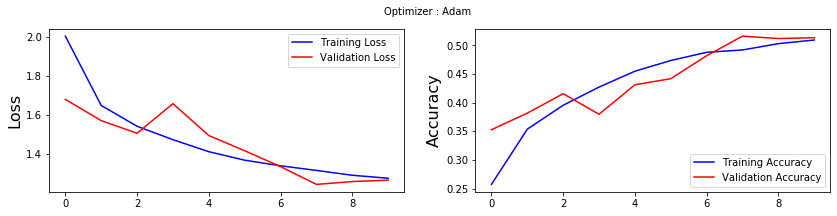

In [15]:
plt.figure(figsize=(14,3))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : Adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(hist.history['loss'], color='b', label='Training Loss')
plt.plot(hist.history['val_loss'], color='r', label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(hist.history['accuracy'], color='b', label='Training Accuracy')
plt.plot(hist.history['val_accuracy'], color='r', label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()